In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Linear Support Vector Machines


##### D.Vidotto,  M. Shafiee Kamalabad, S. Hess, Data Mining: JBI030 2020/2021


=================================================================================================================

**Linear Support Vector Machines** (SVM) is a classifier that, similarly to **logistic regression**, tries to find a **linear boundary** to separate the classes. Unlike Logistic Regression, however, SVM finds such a boundary under a **geometric perspective**, rather than a probabilistic one. 

In this notebook, we will review such concepts and will see how to implement SVM in Python: 
1. SVM for Linearly Separable Data 
  * Geometric Intuition
  * The optimization problem
  * Decision function, predictions, and comparison with Logistic Regression
1. SVM for Non-Separable Data 
  * The slack variables
  * The New Optimization Problem
  * Regularization 
1. SVM: Other remarks
1. Examples in Python 
  * Two-Class case
  * Multi-Class case
1. Application to the Heart dataset  

## 1. SVM for Linearly Separable Data 
### 1.1 Geometric Intuition
Consider the following dataset (2 features; and 2 classes called -1 (negative class) and 1, the positive class): 

<img src="./img/linear_svm/lin_sep_svm.png" width="350" height="50"/>

In this case the classes are said to be **linearly separable**: there is at least **one straight line** (a hyperplane in multiple dimensions) that can perfectly separate examples of the negative class from examples of the positive class. Actually, the **number** of linear boundaries that we can find to divide the two classes is potentially **infinite**:  

<img src="./img/linear_svm/lin_sep_svm_separated.png" width="350" height="50"/>

The **[Perceptron](https://en.wikipedia.org/wiki/Perceptron)** (not covered in this course) is an **algorithm** that finds a separating hyperplane in case of **linearly separable** data, as the ones shown in this example. However, the Perceptron will **rarely** find a **unique** solution: it can find potentially an **infinite** number of hyperplanes as we slightly perturb the training sample, or as we modify the starting values of its algorithm. 

**Support Vector Machines** is a Machine Learning algorithm that allows finding a **unique** and stable solution by finding a well-defined hyperplane: the one that is **equally distant** from both classes. 

Thus, if we define the **margin** as the **shortest distance** between the **hyperplane** and the **closest data** point, SVM seeks to find the **maximum margin hyperplane**: that is, the hyperplane that **maximizes the distances** (the margins) from the data points of both classes. Consider the following two hyperplanes for the dataset introduced above: 

<img src="./img/linear_svm/svm_two_hyperplanes.png" width="800" height="50"/>


It seems clear from the figure that the hyperplane on the right is better than the one on the left, as it seems **equally far away** from the closes examples of both classes (the hyperplane on the left seems much closer to the positive class), and therefore it looks reasonable to assume that it can **generalize** better to new examples. 

Indeed, the hyperplane of the right plot is the *maximum margin hyperplane* found by fitting SVM on the dataset. By definition, it leaves exactly the same distance from the closest point of the two classes: 


<img src="./img/linear_svm/svm_support_vectors.png" width="350" height="50"/>

The **circled data** points are the **closest** to the optimal hyperplane; such points are called **support vectors** (hence the algorithm name). The **dashed lines** represent the **two margins** of this maximum margin hyperplane; by definition, the distances of the support vectors from the hyperplane are exactly the same for both the positive and the negative class. 

Notice that, **once trained**, SVM only needs the support vectors to **define the hyperplane** (discarding the remaining data points), and therefore to perform predictions. 

**Similar** to **logistic regression**, predictions occur by considering in which part of the hyperplane the new data points fall, and classifying it accordinly. **Unlike** logistic regression, however, SVM **doesn't use a probabilistic** model, and therefore it cannot be interpreted probabilistically. 


This type of margin found by SVM is also known as **hard margin**, as it seeks to **perfectly** separate the two classes, not allowing for miss-classifications of the data points. We are now going to review the model more formally. 


## 1.2 The optimization problem 
Here we are going to use the following notation: 
* $y_i \in \{-1,1\}$, where -1 denoted the negative class and 1 the positive class (As seen for the logistic regression model, the labels are encoded internally by `scikit-learn` during the optimization stage)
* The *linear decision function* for observation $i$ is defined as $f(\mathbf{x})=w_0+\mathbf{w}^T\mathbf{x}_i=w_0+w_1x_{i1}+...+w_px_{ip}$, where the weights (or coefficients) vector $\mathbf{w}=[w_1,....,w_p]$ and the $i$-th unit vector $\mathbf{x}_i=[x_{i1},...,x_{ip}]$ are defined analogously to what done in the logistic regression notebook, and the same for the *bias* (or intercept) term $w_0$ 
* the optimal hyperplane (the decision boundary) is defined by all those points $x_1,...,x_p$ such that $w_0+\mathbf{w}^T\mathbf{x}=0$; this will be denoted with $\mathcal{H}_{w_0,\mathbf{w}}=\{x: w_0+\mathbf{w}^T\mathbf{x}=0\}$
* we use the **Euclidean norm** to define the **length of a vector**; such norm is denoted with $||\mathbf{w}||_2=\sqrt{\sum_{j=1}^{p}w_j^2}$ (to simplify notation, the subscript $_2$ will be dropped, and the norm will be simply denoted with $||\mathbf{w}||$)

With the help of a graph we are going to add some other definitions before delving into the optimization problem: 

<img src="./img/linear_svm/svm_definitions.png" width="900" height="50"/>

From the figures we can retrieve the following information: 
* the weights vector $\mathbf{w}$ is orthogonal to the hyperplane (by definition) 
* the (normalized) distance between each margin (and therefore the support vectors) and the optimum hyperplane is $\frac{1}{||\mathbf{w}||}$ (more on this shortly); the total margin size is therefore $\frac{2}{||\mathbf{w}||}$
* the equations for the hard margins are $w_0+\mathbf{w}^T\mathbf{x}=1$ (margin of the positive class) and $w_0+\mathbf{w}^T\mathbf{x}=-1$ (margin of the negative class)
* the *projection* of a generic point $\mathbf{x}$ onto the hyperplane is denoted with $\mathbf{x}_p$, and the vector $\mathbf{d}$ contains the distances between the coordinates of $\mathbf{x}$ and the coordinates of its projection ($\mathbf{d} = \mathbf{x} - \mathbf{x}_p$)

Now, how do we formalize the SVM model? 

* Consider the projection of a generic point $\mathbf{x}$, namely $\mathbf{x}_p = \mathbf{x}-\mathbf{d}$: because it lies in the hyperplane, we know that $w_0+\mathbf{w}^T\mathbf{x}_p = 0$ and as a consequence $$w_0+\mathbf{w}^T(\mathbf{x}-\mathbf{d}) = 0$$
<br>
* because $\mathbf{w}$ and $\mathbf{d}$ point to the same direction (for any $\mathbf{x})$, we can see $\mathbf{d}$ as a rescaled version of the weights vector, $\mathbf{d}=c \cdot\mathbf{w}$ with $c$ a real scalar; therefore $$w_0+\mathbf{w}^T(\mathbf{x}-c\cdot\mathbf{w}) = 0$$
<br>
* solving the above equation for $c$, we obtain $c=\frac{w_0+\mathbf{w}^T\mathbf{x}}{\mathbf{w}^T\mathbf{w}}$ and in turn $\mathbf{d}=\frac{w_0+\mathbf{w}^T\mathbf{x}}{\mathbf{w}^T\mathbf{w}}\mathbf{w}$
<br>
* the total length of the distance $\mathbf{d}$ between the point and the plane is the Euclidean norm $||\mathbf{d}||$, which is equal to 
<br> 

$$||\mathbf{d}|| = \sqrt{\mathbf{d}^T\mathbf{d}} = |c|\cdot\sqrt{\mathbf{w}^T\mathbf{w}} = 
\frac{|w_0+\mathbf{w}^T\mathbf{x}|}{\mathbf{w}^T\mathbf{w}}\sqrt{\mathbf{w}^T\mathbf{w}} = 
\frac{|w_0+\mathbf{w}^T\mathbf{x}|}{||\mathbf{w}||} $$

* across all the training data points $\mathbf{x}_1,...,\mathbf{x}_n$, we are interested in finding those points that minimize such distance for a given value of $w_0$ and $\mathbf{w}$, and therefore we are interested in the following minimization problem: <br> $$ \delta(w_0,\mathbf{w}) = \min_{\mathbf{x}_{1},...,\mathbf{x}_n} \frac{|w_0+\mathbf{w}^T\mathbf{x}_i|}{||\mathbf{w}||} $$ <br> where $\delta(w_0,\mathbf{w})$ is the *margin* of the hyperplane defined by $w_0$ and $\mathbf{w}$

* now, across all  $w_0$ in $\mathbb{R}$ and $\mathbf{w}$ in $\mathbb{R}^p$, the final goal is to find the optimum values $w_0^{opt}$ and $\mathbf{w}^{opt}$ that lead to a hyperplane which *maximizes* the margins (i.e., which maximizes the distances from the training data points): <br> $$w_0^{opt},\mathbf{w}^{opt} = \max_{w_0,\mathbf{w}} \delta(w_0,\mathbf{w}) = \max_{w_0,\mathbf{w}}\left[\min_{\mathbf{x}_{1},...,\mathbf{x}_n} \frac{|w_0+\mathbf{w}^T\mathbf{x}_i|}{||\mathbf{w}||}\right] $$
<br>
* the problem is **incomplete**: we are not specifying that the optimal hyperplane must **lie in between** the **two classes** (and therefore a solution such as $-\infty$ or $\infty$ is the  optimal one at the moment); to add this requirement, we must **constrain** the optimization problem. 

* The constrain must state that the observations all lie in the right side of the hyperplane, which is equivalent to say that $y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0\ \forall i$ (check this result by yourself, with the help of the plot above). The new optimization problem becomes <br><br>$$\max_{w_0,\mathbf{w}}\left[\min_{\mathbf{x}_{1},...,\mathbf{x}_n} \frac{|w_0+\mathbf{w}^T\mathbf{x}_i|}{||\mathbf{w}||}\right]$$<br>$$\ subject\ to\ y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0\ \forall i$$

* it is possible to simplify the problem: 
  1. in the solution for the margins, $||\mathbf{w}||$ is constant for the $\mathbf{x}_i$'s and can be pulled outside the minimization problem:<br>$$\max_{w_0,\mathbf{w}}\frac{1}{||\mathbf{w}||}\left[\min_{\mathbf{x}_{1},...,\mathbf{x}_n} |w_0+\mathbf{w}^T\mathbf{x}_i|\right]$$<br>$$\ s.t.\  y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0\ \forall i$$
  <br>
  1. the hyperplane and the margins are "scale-invariant": $\mathcal{H}_{w_0,\mathbf{w}} = \mathcal{H}_{k\cdot w_0,k\cdot\mathbf{w}}$ and  $\delta(w_0,\mathbf{w}) = \delta(k\cdot w_0,k\cdot\mathbf{w})$ for any $k \neq 0$: we can obtain different solutions for $\mathbf{w}$ and $w_0$, but the hyperplane is the same; we can use this fact to choose a scale for the bias and the coefficients such that <br> $$\min_{\mathbf{x}_{1},...,\mathbf{x}_n} |w_0+\mathbf{w}^T\mathbf{x}_i| = 1$$ <br> and the new optimization problem can be reformulated as <br>$$\max_{w_0,\mathbf{w}}\frac{1}{||\mathbf{w}||}$$<br>$$\ s.t.\ 
\left\{
\begin{array}{l}
y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0\ \forall i \\
\min_{\mathbf{x}_{1},...,\mathbf{x}_n} |w_0+\mathbf{w}^T\mathbf{x}_i| = 1\ \forall i
\end{array}
\right.
 $$<br> Notice that this is what we observed on the left plot above: the margin is now "fixed" to have a length of $\frac{1}{||\mathbf{w}||}$, and our goal is to find the values of $w_0$ and $\mathbf{w}$ that maximize such length 
 1. the maximization problem can be easily reformulated as a minimization problem:<br>$$\min_{w_0,\mathbf{w}}\mathbf{w}^T\mathbf{w}$$<br>$$\ s.t.\
\left\{
\begin{array}{l}
y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0\ \forall i \\
\min_{\mathbf{x}_{1},...,\mathbf{x}_n} |w_0+\mathbf{w}^T\mathbf{x}_i| = 1\ \forall i
\end{array}
\right. 
$$<br> 
 1. last, the constraints can be also simplified; (a) $y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 0$ can be joined to (b) $\min_{\mathbf{x}_{1},...,\mathbf{x}_n} |w_0+\mathbf{w}^T\mathbf{x}_i| = 1$, implying that <br> (c) $\forall\ i,\ y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 1$ (this is true, as all points are on the correct side of the hyperplane, the absolute values can be replaced by the multiplication by $y_i$, and their minimum is equal to 1); but the opposite is also true, that is, knowing (c) implies (a) and (b): if $y_i(w_0+\mathbf{w}^T\mathbf{x}_i)$ was larger than one, we can still minimize (rescale) $\mathbf{w}$ and $w_0$ s.t. the minimum becomes one, making (a) and (b) automatically true


Thus, the final optimization problem is: 

$$\min_{w_0,\mathbf{w}}\mathbf{w}^T\mathbf{w}$$<br>$$\ s.t.\ y_i(w_0+\mathbf{w}^T\mathbf{x}_i) \geq 1\ \forall i$$
<br> 
Notice that the *support vectors* are those data points for which the constraint $y_i(w_0+\mathbf{w}^T\mathbf{x}_i)$ is equal to 1. 

This problem is a Quadratic Programming (QP) otpimization problem, where the objective function to be minimized is quadratic ($\mathbf{w}^T\mathbf{w}$), and the constraint is linear: this implies that a unique solution exists. 

There is a number of libraries and softwares that can help to find solutions to QP problems; scikit-learn, for example, uses [liblinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/). How such libraries work is beyond the scope of this course; it is important, though, to be aware of the kind of optimization problem SVM is solving.  

### 1.3 Decision function, predictions, and comparison with Logistic Regression
SVM shares some similarities, while having some profound differences, with the logistic regression (LR) model: 
* similar to LR, the decision function of linear SVM $f(\mathbf{x})$ is the linear combination of the features (with the weights), $w_0+\mathbf{w}^T\mathbf{x}_i$; as a matter of fact, the two models often lead to similar results  
* similar to LR, a new instance $\mathbf{x}^*$ is predicted to the positive class if $f(\mathbf{x}^*) \geq 0$ and to the negative class otherwise
* unlike LR, SVM only needs the support vectors to define the optimal separating hyperplane 
* unlike LR, SVM doesn't have a probabilistic interpreation, but only a geometrical one; therefore, it doesn't return probabilities, but only the values of the decision function.
* quantities such as ROC curve and P/R curves can be computed using the decision function, and setting $0$ as the 'default threshold'.

In the plot below, you can see the decision boundaries found by (unregularized) LR and (hard-margins) SVM for the dataset introduced above. As you can notice, the two algorithms lead to very similar boundaries.  


<img src="./img/linear_svm/svm_vs_lr.png" width="350" height="50"/>

## 4. Examples in Python 
We are now going to explore the output of the `LinearSVC` function from the `sklearn.svm` module. In the first part we will see an example in the binary case; in the second, we will see an example with the multiclass case (OvR approach). 

### 4.1 Two-Class Case
We will generate a toy dataset with the `make_classification` function of scikit-learn (we will use the same dataset generated in the notebook of Logistic Regression). Furthermore, we scale the training and test datasets by standardizing them. 

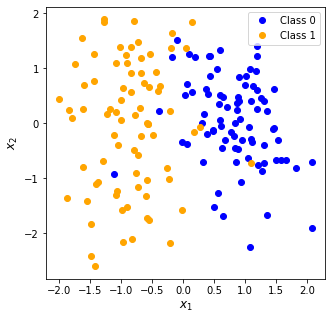

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, 
                           flip_y=0.05, class_sep=0.8, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                   random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
plt.figure(figsize=(5,5))
plt.plot(X_train_scaled[y_train==0,0],X_train_scaled[y_train==0,1], "bo", label="Class 0" )
plt.plot(X_train_scaled[y_train==1,0],X_train_scaled[y_train==1,1], "o", color="orange", label="Class 1" )
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend()
plt.show()

We will show an application of `LinearSVC` with `C=0.5`; notice that this is not necessarily the best value, which should be found by Cross-Validation or with the Holdout Method (By default, LinearSVC has the options `penalty='l2'` and `C=1.0`. More information in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)). 

**Note**: Don't worry about it for now, but, if you must know, C is a valuation of "how badly" you want to properly classify, or fit, everything. The machine learning field is relatively new, and experimental. There exist many debates about the value of C, as well as how to calculate the value for C.

In [3]:
from sklearn.svm import LinearSVC
svm_mod = LinearSVC(C=0.5, random_state=1)
svm_mod.fit(X_train_scaled, y_train)

LinearSVC(C=0.5, random_state=1)

As done with the logistic regression model, we can explore the coefficients vector $\mathbf{w}$: 

In [4]:
svm_mod.coef_

array([[-1.27504899, -0.07158735]])

and the bias term $w_0$: 

In [5]:
svm_mod.intercept_

array([-0.03064091])

We can also calculate the decision function $w_0+\mathbf{w}^T\mathbf{x}$; let's do it for the first five units of the test set: 

In [6]:
svm_mod.decision_function(X_test_scaled[:5])

array([ 0.88282006,  0.48990772, -2.91386911, -1.97222922,  0.06540231])

which suggests us that the first, second, and fifth unit of the test set are predicted to belong to the positive class, while the third and fourth unit to the negative class. Let's confirm our intuition with the `predict` method: 

In [7]:
svm_mod.predict(X_test_scaled[:5])

array([1, 1, 0, 0, 1])

Last, let's plot the data for the found decision boundary and its margins (remember: the *decision boundary* are all those points in the feature space for which the decision function is equal to 0, and the margins all those values for which the decision function is equal to 1 or -1).

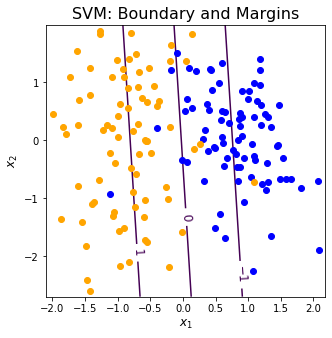

In [8]:
x1_range = np.linspace(X_train_scaled[:,0].min()-0.1, X_train_scaled[:,0].max()+0.1, 100)
x2_range = np.linspace(X_train_scaled[:,1].min()-0.1, X_train_scaled[:,1].max()+0.1, 100)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
df_grid = svm_mod.decision_function(np.c_[xx1.ravel(), xx2.ravel()])
df_grid = df_grid.reshape(xx1.shape)

f, ax = plt.subplots(figsize=(5, 5))
contour = ax.contour(xx1, xx2, df_grid, [-1,0,1],
                     alpha=1., vmin=0, vmax=0)
plt.clabel(contour, inline=1, fontsize=12)
plt.plot(X_train_scaled[y_train==0,0], X_train_scaled[y_train==0,1], 
        "bo", label="Class 0")
plt.plot(X_train_scaled[y_train==1,0], X_train_scaled[y_train==1,1], 
        "o", color="orange", label="Class 1")
plt.title("SVM: Boundary and Margins", fontsize=16)
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.show()

===============================================================================================================================

## Extra topics for interested students: 


===============================================================================================================================


### 4.2 Multiclass case 
As done for the two-class case, we use `make_classification` to generate the same four-class case used with the Logistic Regression model. When more than two classes are chosen, `LinearSVC` selects the option `multi_class='ovr'` approach by default, and so there is no need for us to specify it manually. 

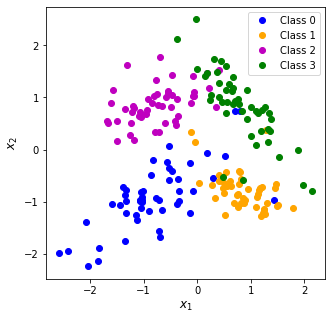

In [9]:
X, y = make_classification(n_samples=240, n_features=2, n_redundant=0, 
                           n_informative=2, n_clusters_per_class=1, n_classes=4, 
                           flip_y=0.05, class_sep=1.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                   random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
plt.figure(figsize=(5,5))
plt.plot(X_train_scaled[y_train==0,0],X_train_scaled[y_train==0,1], "bo", label="Class 0" )
plt.plot(X_train_scaled[y_train==1,0],X_train_scaled[y_train==1,1], "o", color="orange", label="Class 1" )
plt.plot(X_train_scaled[y_train==2,0],X_train_scaled[y_train==2,1], "mo", label="Class 2" )
plt.plot(X_train_scaled[y_train==3,0],X_train_scaled[y_train==3,1], "go", label="Class 3" )
plt.xlabel(r"$x_1$", fontsize=12)
plt.ylabel(r"$x_2$", fontsize=12)
plt.legend()
plt.show()

As done above, let's train a Linear SVM algorithm with `C=0.5` and explore the estimated coefficients: 

In [10]:
svm_mod = LinearSVC(C=0.5, random_state=1)
svm_mod.fit(X_train_scaled, y_train)
svm_mod.coef_

array([[-0.6166792 , -0.78580967],
       [ 0.67132549, -0.73660098],
       [-1.05705138,  0.95259371],
       [ 1.2216767 ,  1.00733756]])

Exactly as seen for the logistic regression model, a set of coefficients is returned for each class (which corresponds to the coefficients estimated for each separate OvR model). The same can be said for the bias terms...

In [11]:
svm_mod.intercept_

array([-0.69492713, -0.84115834, -1.08100257, -1.26944348])

...and for the decision functions (here calculated for the first five units of the test set):

In [12]:
svm_mod.decision_function(X_test_scaled[:5])

array([[-2.00779599, -0.7243988 , -1.43569229,  0.87851401],
       [ 1.4904959 , -0.97954989, -0.57142097, -4.82565474],
       [-0.63271028,  0.16056902, -2.51908316, -1.02364107],
       [-0.55916738, -0.10910394, -2.11914547, -1.23476708],
       [-0.3700162 , -1.93749021,  0.54858348, -2.16938349]])

Thus, test units 1, 2, 3, 4, and 5 are predicted to belong to Classes 3, 0, 1, 1, and 2 respectively:

In [13]:
svm_mod.predict(X_test_scaled[:5])

array([3, 0, 1, 1, 2])

Last, we are going to plot the class-specific estimated decision boundaries: 

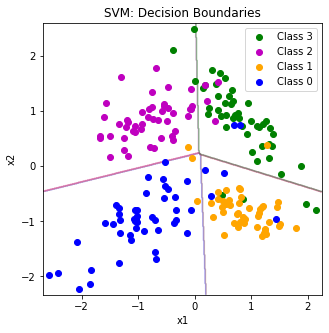

In [14]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['blue','orange','magenta', 'green'])

x0, x1 = np.meshgrid(
        np.linspace(X_train_scaled[:,0].min()-0.1, X_train_scaled[:,0].max()+0.1, 500).reshape(-1, 1),
        np.linspace(X_train_scaled[:,1].min()-0.1, X_train_scaled[:,1].max()+0.1, 500).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = svm_mod.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(5, 5))

plt.plot(X_train_scaled[y_train==3, 0], X_train_scaled[y_train==3, 1],  "go", label="Class 3")
plt.plot(X_train_scaled[y_train==2, 0], X_train_scaled[y_train==2, 1], "mo", label="Class 2")
plt.plot(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1], "o", color="orange", label="Class 1")
plt.plot(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1], "bo", label="Class 0")
plt.contour(x0, x1, zz, cmap=custom_cmap, alpha=0.25)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("SVM: Decision Boundaries")
plt.legend()

plt.show()

Once again, you can see that the decision boundaries found by LinearSVM are not too different from the ones found by Logistic Regression! (Compare it with the graphs plotted in the Logistic Regression notebook.)

### 4.3 LinearSVM in Python, other remarks and exercises
* the `sklear.linear_model` module provides the [SGDclassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) function, which can estimate linear SVM with stochastic gradient descent when `loss='hinge'` is set 
* the option `pnealty='l_1;` is also possible, in which case $l_1$ regularization is performed
* for both the binary and multiclass case, try to plot the decision boundaries (and margins in the binary case) for different values of C, and see how they change 

### 5. Application to the Heart Dataset 
As done for the logistic regression model, we apply also LinearSVM to the heart dataset. We will work with the $l_2$ penalty, and evaluate different values of `C` with 10-fold-cross-validation. As an exercise, try to see whether the $l_1$ penalty performs better than the $l_2$ penalty, and what features are selected with this penalty! 

In [15]:
# 1.Load datasets
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

In [16]:
# 2a. Prepare parameter Grid for elastic-net 
from sklearn.model_selection import GridSearchCV
# For C, we will use a grid of 120 equi-distant values in the log space between 1e-4 and 70
param_grid = {'C': np.exp( np.linspace(np.log(1e-4), np.log(70), 120)) }

# 2b. Run GridSearchCV with 10-fold-cv
clf = GridSearchCV(LinearSVC(max_iter=1e+07, random_state=1), 
                   param_grid, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print("CV Grid Search: Done")

CV Grid Search: Done


Let's visualize the plot of C values vs. CV accuracies: 

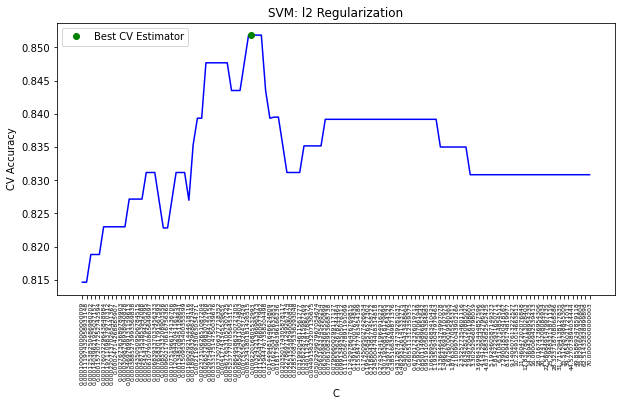

In [17]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="param_C")
plt.figure(figsize=(10,5))
x_ax = np.linspace(0, cv_res.shape[0], cv_res.shape[0])
plt.plot(x_ax, cv_res["mean_test_score"], "b-")
plt.plot(cv_res["mean_test_score"].idxmax()+1,clf.best_score_, "go", label="Best CV Estimator")
plt.xticks(x_ax, (cv_res["param_C"]).astype("float64").round(20), rotation=90, fontsize=6)
plt.xlabel("C")
plt.ylabel("CV Accuracy")
plt.title("SVM: l2 Regularization")
plt.legend(loc=2)
plt.show()

The best CV score is obtained for: 

In [18]:
clf.best_params_

{'C': 0.008234180181426515}

which obtains a CV accuracy of

In [19]:
clf.best_score_

0.8518333333333334

which is in line with the CV accuracy observed with the elastic-net penalty for logistic regression. The final accuracy on the test set is: 

In [20]:
clf.best_estimator_.score(X_test,y_test)

0.8524590163934426

Which is only slightly worse than the test-set accuracy calculated with Logistic Regression. Last, let's see how each features contribute to the final classification of the linear SVM model. How would you interpret this results? 

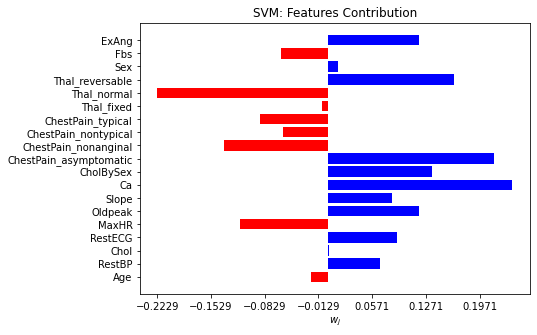

In [21]:
colors = ['r' if coef < 0 else 'b' for coef in clf.best_estimator_.coef_[0]]
plt.figure(figsize=(7,5))
plt.barh(range(X_train.shape[1]), clf.best_estimator_.coef_[0], color=colors)
plt.yticks(range(X_train.shape[1]), X_train.columns)
plt.xticks(np.arange(clf.best_estimator_.coef_[0].min(), clf.best_estimator_.coef_[0].max(),0.07))
plt.xlabel("$w_j$")
plt.title("SVM: Features Contribution")
plt.show()